In [1]:
import math
import time
import random
from collections import deque
from collections import namedtuple
from dataclasses import dataclass

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  #activation function https://pytorch.org/docs/stable/nn.functional.html

from torch.distributions.categorical import Categorical

from torch.profiler import profile, record_function, ProfilerActivity

import gym
import rl_gym

import matplotlib.pyplot as plt

from tqdm import tqdm
import gc


In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    


Using device: cpu


In [112]:
class Adam():
    #https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

    def __init__(self, thetas, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.gamma=lr
        self.beta1=beta1
        self.beta2=beta2
        self.epsilon=epsilon
        self.beta1t=1.
        self.beta2t=1.
        self.m=[]
        self.v=[]
        for i,theta in enumerate(thetas):
            self.m.append(np.zeros_like(theta.detach().numpy()))
            self.v.append(np.zeros_like(theta.detach().numpy()))
        

    def step(self, g, i): #returns the increment in direction of increasing value
        
        if i==0:
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2
        
        self.m[i] = self.beta1 * self.m[i] + (1.-self.beta1)*g.detach().numpy()
        self.v[i] = self.beta2 * self.v[i] + (1.-self.beta2)*np.square(g.detach().numpy())
        mhat = self.m[i]/(1.-self.beta1t)
        vhat = self.v[i]/(1.-self.beta2t)
        return self.gamma * mhat/(np.sqrt(vhat)+self.epsilon)


In [125]:
#--------------------------------
class PolicyNN(nn.Module):

    def __init__(self, num_observations, num_actions, num_neurons):
        super(PolicyNN, self).__init__()
        
        self.layer1 = nn.Linear(num_observations, num_neurons)
        self.layer2 = nn.Linear(num_neurons, num_neurons)
        self.layer3 = nn.Linear(num_neurons, num_actions) #returns the logits of possible actions for the given input state

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)   #logits  - would be F.softmax(self.layer3(x)) to return probas

#--------------------------------
class CriticNN(nn.Module):

    def __init__(self, num_observations, num_neurons):
        super(CriticNN, self).__init__()
        
        self.layer1 = nn.Linear(num_observations, num_neurons)
        self.layer2 = nn.Linear(num_neurons, num_neurons)
        self.layer3 = nn.Linear(num_neurons, 1)  #returns the value of the given input state

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#--------------------------------
#--------------------------------

@dataclass
class RLA2CParams:
    num_policy_neurons: int = 100             #number of neurons in the simple MLP used to compute Q values
    num_critic_neurons: int = 100             #number of neurons in the simple MLP used to compute Q values
    num_steps: int = 600*1000                 #number of training steps: 1000 episodes of 600 steps
    max_episode_length: int = 600             #maximum length of an episode
    policy_learning_rate: float = 0.0001      #learning rate 
    critic_learning_rate: float = 0.0001      #learning rate 
    reward_learning_rate: float = 0.001              #learning rate
    actor_lambda: float = 0.4                 #eligibility trace decay
    critic_lambda: float = 0.4                #eligibility trace decay
    gamma: float = 0.99                       #discount factor
    
class RLA2C():
    def __init__(self, env: gym.Env, params: RLA2CParams, device):
        
        #get input parameters
        self.params = params
        self.num_observations = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.device = device

        self.policy = PolicyNN(num_observations = self.num_observations, num_actions=self.num_actions, num_neurons=self.params.num_policy_neurons).to(self.device)
        self.critic = CriticNN(num_observations = self.num_observations, num_neurons=self.params.num_critic_neurons).to(self.device)

    def train_onestep(self, env, params):
        
        #Sutton-Barto One-Step Actor-Critic (episodic) page 332
        
        self.params = params
        print("start training with params:")
        print(self.params)
        
        optimizer_policy = optim.AdamW(self.policy.parameters(), lr=self.params.policy_learning_rate, amsgrad=True) #https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html
        optimizer_critic = optim.AdamW(self.critic.parameters(), lr=self.params.critic_learning_rate, amsgrad=True) #https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html

        scores = [] #for logging only
        
        I = 1.
        score = 0
        done = False
        obs = env.reset()
        t = 0
                                     
        #main training loop
        pbar = tqdm(range(self.params.num_steps))
        for step in pbar:
            
            #sample the current policy
            logits = self.policy(torch.tensor(obs, dtype=torch.float32, device=self.device)) #get the proba from the current policy
            dist = Categorical(logits=logits)
            action = dist.sample() 
            log_proba = dist.log_prob(action) #log proba of selected action

            #step the model with sampled action
            next_obs, reward, done, info = env.step(action.item())

            v = self.critic(torch.tensor(obs, dtype=torch.float32, device=self.device))
            next_v = self.critic(torch.tensor(next_obs, dtype=torch.float32, device=self.device)) #v'
            delta = reward + (1.-done) * self.params.gamma * next_v - v  
            
            critic_loss = - delta.detach() * v  #- sign because pytorch's optimizer reverses the sign
            
            optimizer_critic.zero_grad()
            critic_loss.backward()
            optimizer_critic.step()
            
            actor_loss = - I * log_proba * delta.detach() #- sign because pytorch's optimizer reverses the sign
            
            optimizer_policy.zero_grad()
            actor_loss.backward()
            optimizer_policy.step()
            
            I *= self.params.gamma
            
            score += reward
            t += 1

            if done or t>self.params.max_episode_length:
                
                done = True
                scores.append(score) #for logging only
                pbar.set_description(f'score:{np.mean(scores[-10:]):.0f}')
                pbar.refresh()
                
                score = 0
                t = 0

                I = 1.
                next_obs = env.reset()
            
            obs = next_obs
                
        return scores

    def train_eligibility(self, env, params):
        
        #Sutton-Barto Actor-Critic with Eligibility Traces (episodic) page 332
        
        self.params = params
        print("start training with params:")
        print(self.params)
        
        scores = [] #for logging only
        
        I = 1.
        score = 0
        done = False
        obs = env.reset()
        t = 0
        actor_trace = [] 
        critic_trace = [] 
        
        actor_optim = Adam(self.policy.parameters(), lr=self.params.policy_learning_rate)
        critic_optim = Adam(self.critic.parameters(), lr=self.params.critic_learning_rate)
        
        #main training loop
        pbar = tqdm(range(self.params.num_steps))
        for step in pbar:
            
            #sample the current policy
            logits = self.policy(torch.tensor(obs, dtype=torch.float32, device=self.device)) #get the proba from the current policy
            dist = Categorical(logits=logits)
            action = dist.sample() 
            log_proba = dist.log_prob(action) #log proba of selected action

            #step the model with sampled action
            next_obs, reward, done, info = env.step(action.item())

            #train the agent

            v = self.critic(torch.tensor(obs, dtype=torch.float32, device=self.device))

            #update the critic eligibility trace
            
            self.critic.zero_grad()
            v.backward()
            if t==0:
                for p in self.critic.parameters():
                    #initialize trace 
                    critic_trace.append(p.grad)
            else:
                for i, p in enumerate(self.critic.parameters()):
                    #update the trace = decay and shift in direction of gradient
                    critic_trace[i] = critic_trace[i] * self.params.critic_lambda * self.params.gamma + p.grad
            
            #update the actor's eligibility trace

            self.policy.zero_grad()
            log_proba.backward()
            if t==0:
                for p in self.policy.parameters():
                    #initialize trace 
                    actor_trace.append(I * p.grad)
            else:
                for i, p in enumerate(self.policy.parameters()):
                    #update the trace = decay and shift in direction of gradient
                    actor_trace[i] = actor_trace[i] * self.params.actor_lambda * self.params.gamma + I * p.grad

            #update the models
            
            with torch.no_grad():
                
                next_v = self.critic(torch.tensor(next_obs, dtype=torch.float32, device=self.device)) #v'
                delta = reward + (1.-done) * self.params.gamma * next_v - v.detach() 
                
                for i, p in enumerate(self.policy.parameters()):
                    #new_val = p + self.params.policy_learning_rate * delta * actor_trace[i]
                    inc = actor_optim.step(delta*actor_trace[i], i)
                    new_val = p + inc
                    p.copy_(new_val)
                
                
                for i, p in enumerate(self.critic.parameters()):
                    #new_val = p + self.params.critic_learning_rate * delta * critic_trace[i]
                    inc = critic_optim.step(delta*critic_trace[i], i)
                    new_val = p + inc
                    p.copy_(new_val)
                    
            I *= self.params.gamma
            
            score += reward
            t += 1

            if done or t>self.params.max_episode_length:
                
                done = True
                scores.append(score) #for logging only
                pbar.set_description(f'score:{np.mean(scores[-10:]):.0f}')
                pbar.refresh()
                
                score = 0
                t = 0

                I = 1.
                next_obs = env.reset()
                actor_trace = []
                critic_trace = []
            
            obs = next_obs
                
        return scores

    def train_continuing(self, env, params):
        
        #Sutton-Barto Actor-Critic with Eligibility Traces (continuing) page 332
        
        self.params = params
        print("start training with params:")
        print(self.params)
        
        scores = [] #for logging only
        
        score = 0
        done = False
        obs = env.reset()
        t = 0
        actor_trace = [] 
        critic_trace = [] 
        Rbar = 0
                                     
        #main training loop
        pbar = tqdm(range(self.params.num_steps))
        for step in pbar:
            
            #sample the current policy
            logits = self.policy(torch.tensor(obs, dtype=torch.float32, device=self.device)) #get the proba from the current policy
            dist = Categorical(logits=logits)
            action = dist.sample() 
            log_proba = dist.log_prob(action) #log proba of selected action

            #step the model with sampled action
            next_obs, reward, done, info = env.step(action.item())

            #train the agent

            v = self.critic(torch.tensor(obs, dtype=torch.float32, device=self.device))

            #update the critic eligibility trace
            
            self.critic.zero_grad()
            v.backward()
            if t==0:
                for p in self.critic.parameters():
                    #initialize trace 
                    critic_trace.append(p.grad)
            else:
                for i, p in enumerate(self.critic.parameters()):
                    #update the trace = decay and shift in direction of gradient
                    critic_trace[i] = critic_trace[i] * self.params.critic_lambda * self.params.gamma + p.grad
            
            #update the actor's eligibility trace

            self.policy.zero_grad()
            log_proba.backward()
            if t==0:
                for p in self.policy.parameters():
                    #initialize trace 
                    actor_trace.append(p.grad)
            else:
                for i, p in enumerate(self.policy.parameters()):
                    #update the trace = decay and shift in direction of gradient
                    actor_trace[i] = actor_trace[i] * self.params.actor_lambda * self.params.gamma + p.grad

            #update the models
            
            with torch.no_grad():
                
                next_v = self.critic(torch.tensor(next_obs, dtype=torch.float32, device=self.device)) #v'
                delta = reward - Rbar + (1.-done) * self.params.gamma * next_v - v.detach() 

                Rbar += self.params.reward_learning_rate * delta
                
                for i, p in enumerate(self.policy.parameters()):
                    new_val = p + self.params.policy_learning_rate * delta * actor_trace[i]
                    p.copy_(new_val)
                
                for i, p in enumerate(self.critic.parameters()):
                    new_val = p + self.params.critic_learning_rate * delta * critic_trace[i]
                    p.copy_(new_val)
                    
            score += reward
            
            t += 1

            if t>self.params.max_episode_length: #only for logging
                
                scores.append(score) #for logging only
                pbar.set_description(f'score:{np.mean(scores[-10:]):.0f}')
                pbar.refresh()
                score = 0
                t = 0

            obs = next_obs
                
        return scores
    
    def best_action(self, obs):
        with torch.no_grad():
            logits = self.policy(torch.tensor(obs, dtype=torch.float32, device=self.device)) #get the proba from the current policy
            action = torch.max(logits,dim=-1,keepdim=False) #return index of greatest logit, it is the most likely action
            return action.indices.item()
            
        
    def play(self, env):
        obs = env.reset()
        done=False
        while not done:
            env.render()
            action = self.best_action(obs)
            obs, reward, done, info = env.step(action)        
        env.close()
        
    def evaluate(self, env, num_episodes=100, episode_length=600):
        scores=[]
        for e in range(num_episodes):
            obs = env.reset()
            score=0
            done=False
            episode_t=0
            while not done:
                action = self.best_action(obs)
                obs, reward, done, info = env.step(action)
                score += reward
                episode_t +=1
                if episode_t>episode_length: #force episode termination
                    done=True
            scores.append(score)
        mean_reward = np.mean(scores)
        std_reward = np.std(scores)
        return mean_reward, std_reward, scores


            

In [128]:
#env = gym.wrappers.TimeLimit(gym.make("rl_gym/PuckWorld-v0", fps=60), max_episode_steps=600)
env = gym.make("rl_gym/PuckWorld-v0", fps=60)
#env = gym.make("CartPole-v1")

print(device)
params = RLA2CParams()
vpg = RLA2C(env, params, device)

start_time = time.time()
mean_reward, std_reward, scores = vpg.evaluate(env, num_episodes=100, episode_length=600)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
print("--- %.1f seconds ---" % (time.time() - start_time))
#print(scores)

cpu
mean_reward:-576.40 +/- 262.05
--- 7.5 seconds ---


train
start training with params:
RLA2CParams(num_policy_neurons=100, num_critic_neurons=100, num_steps=600000, max_episode_length=600, policy_learning_rate=0.0001, critic_learning_rate=0.0001, reward_learning_rate=0.001, actor_lambda=0.4, critic_lambda=0.4, gamma=0.99)


score:-613: 100%|█████████████████████████████████████████████████████████████| 600000/600000 [34:42<00:00, 288.14it/s]


--- 34.7 minutes ---


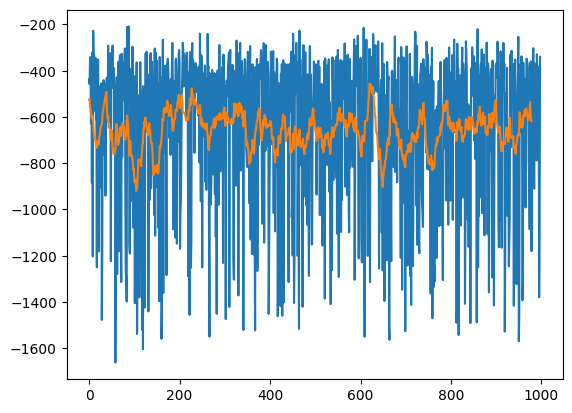

evaluate
--- 7.572999000549316 seconds ---
mean_reward:-688.76 +/- 343.77


In [129]:
params = RLA2CParams()

print('train')
start_time = time.time()
scores = vpg.train_eligibility(env, params)
print("--- %.1f minutes ---" % ((time.time() - start_time)/60))

plt.plot(scores)
window=20
y = np.array(scores)
plt.plot(np.convolve(y, np.ones(window)/window, mode='valid'))
plt.show()

print('evaluate')
start_time = time.time()
mean_reward, std_reward, scores = vpg.evaluate(env, num_episodes=100, episode_length=600)
print("--- %s seconds ---" % (time.time() - start_time))
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")



In [104]:
a=[1,2,3,4]
a[-10:]

[1, 2, 3, 4]